# Projet Python :  Classification Multi-Output sur les données MBTI

Les données viennent du site Kaggle et sont disponibles à ce lien :
https://www.kaggle.com/datasnaek/mbti-type.
Nous nous sommes inspirés de certains notebooks disponibles sur ce même lien ( les notebooks de @depture et de @brunnoricci).


## Introduction

Le but de ce notebook est d'expérimenter les réseaux de neurones à sorties multiples. 

La base de données que l'on a choisi est un ensemble de posts postés par des individus sur un forum appelé le "personality cafe".
Il y a 8675 individus et 50 posts pour chaque individu.

On souhaite créér un réseau de neurones capable de prédire le type psychologique (selon le MBTI) de chaque individu en analysant les textes qu'ils ont écrit. Chaque individu a donc préalablement réaliser le test MBTI et communiqué ces résultats.

Le Myers Briggs Type Indicator (MBTI) est un outil d'évaluation psychologique déterminant le type psychologique d'un sujet parmi 16 types différents, suivant une méthode proposée en 1962 par Isabel Briggs Myers et Katherine Cook Briggs.

Il sert comme outil dans les identifications des dominantes psychologiques des personnes dans des cadres liés au management ou aux problèmes dans le cadre des relations interpersonnelles.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Préparation de la BDD

Nous entamons bien évidemment la préparation de la base de données en 
l'important.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/My Drive/Projet_Fevrier/mbti_data.csv", sep=",") 

Nous pouvons dans un premier temps regarder la répartition des résultats que les utilisateurs ont obtenu au test. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


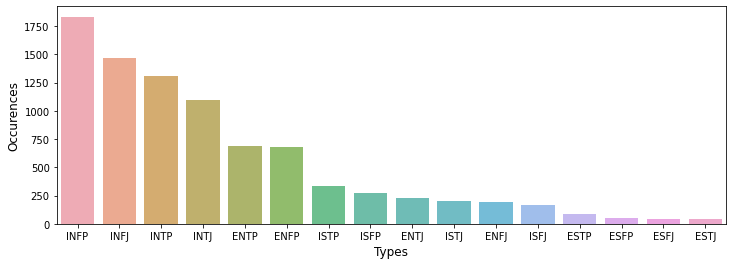

In [ ]:
cnt_srs = df['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Occurences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

Ainsi, on remarque une majorité de INFP, suivi par les INFJ puis les INTP. On remarque que la lettre "I" pour Introverti apparaît beaucoup plus souvent, ce que nous allons confirmer par la suite. 

Ici, nous allons diviser en 4 axes pour les différents traits de caractères analysés. 

In [ ]:
df2 = df.copy()
taille_df = len(df2)

df2['Axe1'] = "Introversion"
df2['Axe2'] = "Intuition"
df2['Axe3'] = "Thinking"
df2['Axe4'] = "Judging"
for i in range(taille_df):
  if "E" in df2['type'][i]:
    df2['Axe1'][i] = "Extraversion"
  if "S" in df2['type'][i]:
    df2['Axe2'][i] = "Sensing"
  if "F" in df2['type'][i]:
    df2['Axe3'][i] = "Feeling"
  if "P" in df2['type'][i]:
    df2['Axe4'][i] = "Perceiving"

df2.drop(['type'], axis='columns', inplace=True)

df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
df2.head()

,posts,Axe1,Axe2,Axe3,Axe4
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging
1,'I'm finding the lack of me in these posts ver...,Extraversion,Intuition,Thinking,Perceiving
2,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving
3,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging
4,'You're fired.|||That's another silly misconce...,Extraversion,Intuition,Thinking,Judging


Une fois cela fait, on peut regarder la répartition des résultats pour chaque axe. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

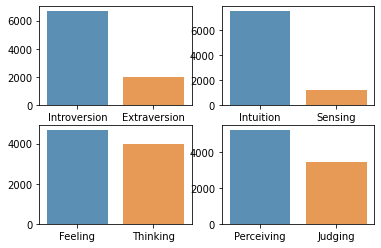

In [ ]:
ratio = []
for i in range (1,5):
  cnt = df2["Axe"+str(i)].value_counts()
  ratio.append(max(cnt)/sum(cnt))
  plt.subplot(2,2,i)
  sns.barplot(cnt.index, cnt.values, alpha=0.8)
plt.show()

On remarque ici qu'il y a beaucoup plus d'individus introvertis qu'extravertis, et ce phénomène est encore accentué entre les individus plutôt intuitifs que sensitifs, et enfin, la répartition est légèrement plus équivalente pour les 2 autres axes. 

Continuons maintenant notre analyse en travaillant sur les posts qu'ont écrit les individus. On retrouve ci-dessous les différents posts d'un internaute. On coupe entre chaque triple barre pour séparer chaque post de chaque individu.

In [ ]:
[p.split('|||') for p in df2.head(1).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

## Traitement du texte

Avant de commencer l'analyse, il faut d'abord traiter les posts des individus. 

On a pu remarquer que certains individus postaient des liens de page internet, ce qui n'est pas exploitable. On supprime donc tous les url des posts que l'on remplace simplement par le mot "link".

Ensuite, on décide de conserver uniquement les mots, on supprime donc toute la ponctuation, les symboles et les espaces inutiles entre les mots.

On enlève également tous les mots qualifiés de "stopwords" qui n'apportent pas de sens mais qui sont là uniquement pour que la phrase soit correcte (par exemple : the, a, an, I, because, why, once, my...). En anglais, il y en a 127.

Enfin, on pratique sur nos données ce qu'on appelle la lemmatisation qui a pour but de regrouper les mots de la même famille. On remplace tous les mots de la même famille par un seul mot (appelé la forme canonique), cela permet de réduire le nombre de mots dans notre base de données et donc de simplifier l'analyse. Par exemple, le mot "better" est remplacé par "good".



On tente de faire d'abord tout ça sur un seul post pour voir ce que cela donne :

In [ ]:
import nltk, re
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


# Lemmatizer | Stemmatizer
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

OnePost = df2.posts[2]

# List all urls
urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', OnePost)

# Remove urls
temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', OnePost)

# Keep only words
temp = re.sub("[^a-zA-Z]", " ", temp)

# Remove spaces > 1
temp = re.sub(' +', ' ', temp).lower()

# Remove stopwords and lemmatize
temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])

print("\nBefore preprocessing:\n\n", OnePost[0:500])
print("\nAfter preprocessing:\n\n", temp[0:500])
print("\nList of urls:")
urls

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.

Before preprocessing:

 'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your own t

After preprocessing:

  good one link course say know blessing curse absolutely positive best friend could amazing couple count yes could madly love case reconciled feeling thank link called ti si loop stem current topic obsession deadly like stuck though

['https://www.youtube.com/watch?v=fHiGbolFFGw',
 'https://www.tumblr.com/blog/-alexxxandra-',
 'http://-alexxxandra-.tumblr.com/',
 'http://www.youtube.com/watch?v=2Nkcn8m9M0M',
 "http://www.youtube.com/watch?v=7ghqoYxmaUE'"]

On voit qu'après le traitement les posts ne sont plus très compréhensibles lorsqu'on les lit mais ce traitement permet de garder l'essentiel et prépare les données pour les réseaux de neurones.

Enfin, on fait ce traitement sur la totalité des posts :

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words=True):
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
    i+=1
    if i % int(len_data/20) == 0:
      percent = i/len_data
      print(f"{round(percent*100,0)}")

    posts = row[1].posts
    temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', posts)
    temp = re.sub("[^a-zA-Z]", " ", temp)
    temp = re.sub(' +', ' ', temp).lower()
    if remove_stop_words:
      temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
    else:
      temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

    list_posts.append(temp)

  list_posts = np.array(list_posts)
  return list_posts

list_posts = pre_process_data(df2, remove_stop_words=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


Voilà à quoi ressemblent les posts après traitement :

In [ ]:
list_posts

array([' link link enfp intj moment link sportscenter top ten play link prank life changing experience life link link repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace link hello enfj sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth link link welcome stuff link game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear enfp favorite video game growing current favorite video game cool link appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time work

On utilise la technique de tokenization.

In [ ]:
from keras.preprocessing.text import Tokenizer

max_nb_words = 200000
X = list_posts

tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#Retokenize
max_nb_words = len(word_index)
tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88838 unique tokens.
Found 88838 unique tokens.


Il y a 88 838 mots différents présents dans la totalité des posts des individus. On décide de garder la totalité.

On créé donc un dictionnaire avec un numéro associé à chaque mot que l'on classe par occurence.  



In [ ]:
import numpy as np
from keras.preprocessing import sequence

max_post_len = np.max([len(x) for x in sequences])
sequences = sequence.pad_sequences(sequences, maxlen=max_post_len)
sequences

array([[    0,     0,     0, ...,   163,   117,    30],
       [    0,     0,     0, ...,    18,    18,    94],
       [    0,     0,     0, ...,   915,   198,    11],
       ...,
       [    0,     0,     0, ..., 11433,  2091,    62],
       [    0,     0,     0, ...,  1216,  1107,   102],
       [    0,     0,     0, ...,    89,    58,    38]], dtype=int32)

Le nombre maximal de mots utilisés par un individus dans ses 50 posts est 921. On créé donc un vecteur de taille 921 pour chaque individu dans lequel on stocke les mots qu'il a utilisé (représentés par leurs numéros). La plupart des vecteurs commencent par des 0 car ils sont de taille inférieure à 921 et on remplit donc le début du vecteur avec des 0 pour qu'ils soient quand même tous de même taille.

On créé y qui est constitué de 4 vecteurs (un par axe) constitués uniquement de 0 ou de 1. 
Par exemple, pour le 1er vecteur la première coordonnée vaut 1 car le 1er individu est introverti et la 2ème vaut 0 car le 2ème individu de la base est extraverti.
Cela fonctionne de la même manière pour les 3 autres vecteurs.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y= []
for i in range(4):
  y.append(le.fit_transform(df2["Axe"+str(i+1)]))
y

[array([1, 0, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 1, ..., 1, 0, 0]),
 array([0, 1, 1, ..., 1, 1, 1])]

## Création de modèles

On divise nos données en échantillons d'entraînement, validation et test pour chaque axe. On choisit d'abord une taille d'échantillon test de 0.1. On prend donc 10% de la base de données que l'on considère comme échantillon test (à faire pour chaque axe).
Ensuite, la taille de l'échantillon de validation est aussi fixée à 0.1.
On prend donc 10% de ce qu'il reste de la base de données.
Enfin le reste est l'échantillon d'entraînement.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test = train_test_split(sequences, 
                                                                                                               y[0], y[1], y[2], y[3], 
                                                                                                               test_size=0.1, 
                                                                                                               random_state=777)

X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val, y4_train, y4_val = train_test_split(X_train,
                                                  y1_train, y2_train, y3_train, y4_train,
                                                  test_size = 0.1,
                                                  random_state = 777)

On peut afficher la taille de chacun des échantillons. 

In [ ]:
print("x_train shape = ", X_train.shape)
print("y_train shape = ", y1_train.shape, y2_train.shape, y3_train.shape, y4_train.shape)
print("\nx_validation shape = ", X_val.shape)
print("y_validation shape = ", y1_val.shape, y2_val.shape, y3_val.shape, y4_val.shape)
print("\nx_test shape = ", X_test.shape)
print("y_test shape = ", y1_test.shape, y2_test.shape, y3_test.shape, y4_test.shape)

x_train shape =  (7026, 921)
y_train shape =  (7026,) (7026,) (7026,) (7026,)

x_validation shape =  (781, 921)
y_validation shape =  (781,) (781,) (781,) (781,)

x_test shape =  (868, 921)
y_test shape =  (868,) (868,) (868,) (868,)


### 1er essai de modèle

On utilise du "word embedding" qui est une technique qui permet de représenter chaque mot d'un dictionnaire par un vecteur de nombres réels. Cette représentation est telle que les mots apparaissant dans des contextes similaires possèdent des vecteurs correspondants qui sont relativement proches. Par exemple, on pourrait s'attendre à ce que les mots « chien » et « chat » soient représentés par des vecteurs relativement peu distants dans l'espace vectoriel où sont définis ces vecteurs.

On utilise du drop out, un noyau de régularisation et un petit nombre de neurones par couche pour éviter le surapprentissage.

On a fait 2 branches afin de tester l'implémentation de ce type de réseau de neurones non-séquentiels et voir ce que cela peut apporter.
Cependant, ici les 2 branches sont similaires donc il y a pas vraiment d'intérêt.

On a 4 sorties qui sont en fait des problèmes de classification binaire donc on utilise la fonction d'activation sigmoïde.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense,  Dropout, concatenate
from keras.layers import LSTM, Conv1D, Input, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras import regularizers

embedding_vector_length = 32
posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = Embedding(max_nb_words, embedding_vector_length, input_length=max_post_len)(posts_input)

x = Conv1D(32, 5, activation='relu')(embedded_posts)
x = Dropout(0.25)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Dropout(0.25)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Dropout(0.25)(x)
x = MaxPooling1D(5)(x)

branche_a = Conv1D(64, 5, activation='relu')(x)
branche_a = Dropout(0.25)(branche_a)
branche_a = Conv1D(64, 5, activation='relu')(branche_a)
branche_a = Dropout(0.25)(branche_a)

branche_b = Conv1D(64, 5, activation='relu')(x)
branche_b = Dropout(0.25)(branche_b)
branche_b = Conv1D(64, 5, activation='relu')(branche_b)
branche_b = Dropout(0.25)(branche_b)

x = concatenate([branche_a, branche_b], axis=-1)

x = GlobalMaxPooling1D()(x)
x = Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = Dropout(0.25)(x)

Axe1_prediction = Dense(1, activation='sigmoid', name='axe1')(x)
Axe2_prediction = Dense(1, activation='sigmoid', name='axe2')(x)
Axe3_prediction = Dense(1, activation='sigmoid', name='axe3')(x)
Axe4_prediction = Dense(1, activation='sigmoid', name='axe4')(x)

model = Model(posts_input, [Axe1_prediction, Axe2_prediction, Axe3_prediction, Axe4_prediction])

Avec Keras, on peut utiliser la fonction plot_model pour représenter de manière plus jolie les modèles.

Voilà ce que ça donne pour le notre :

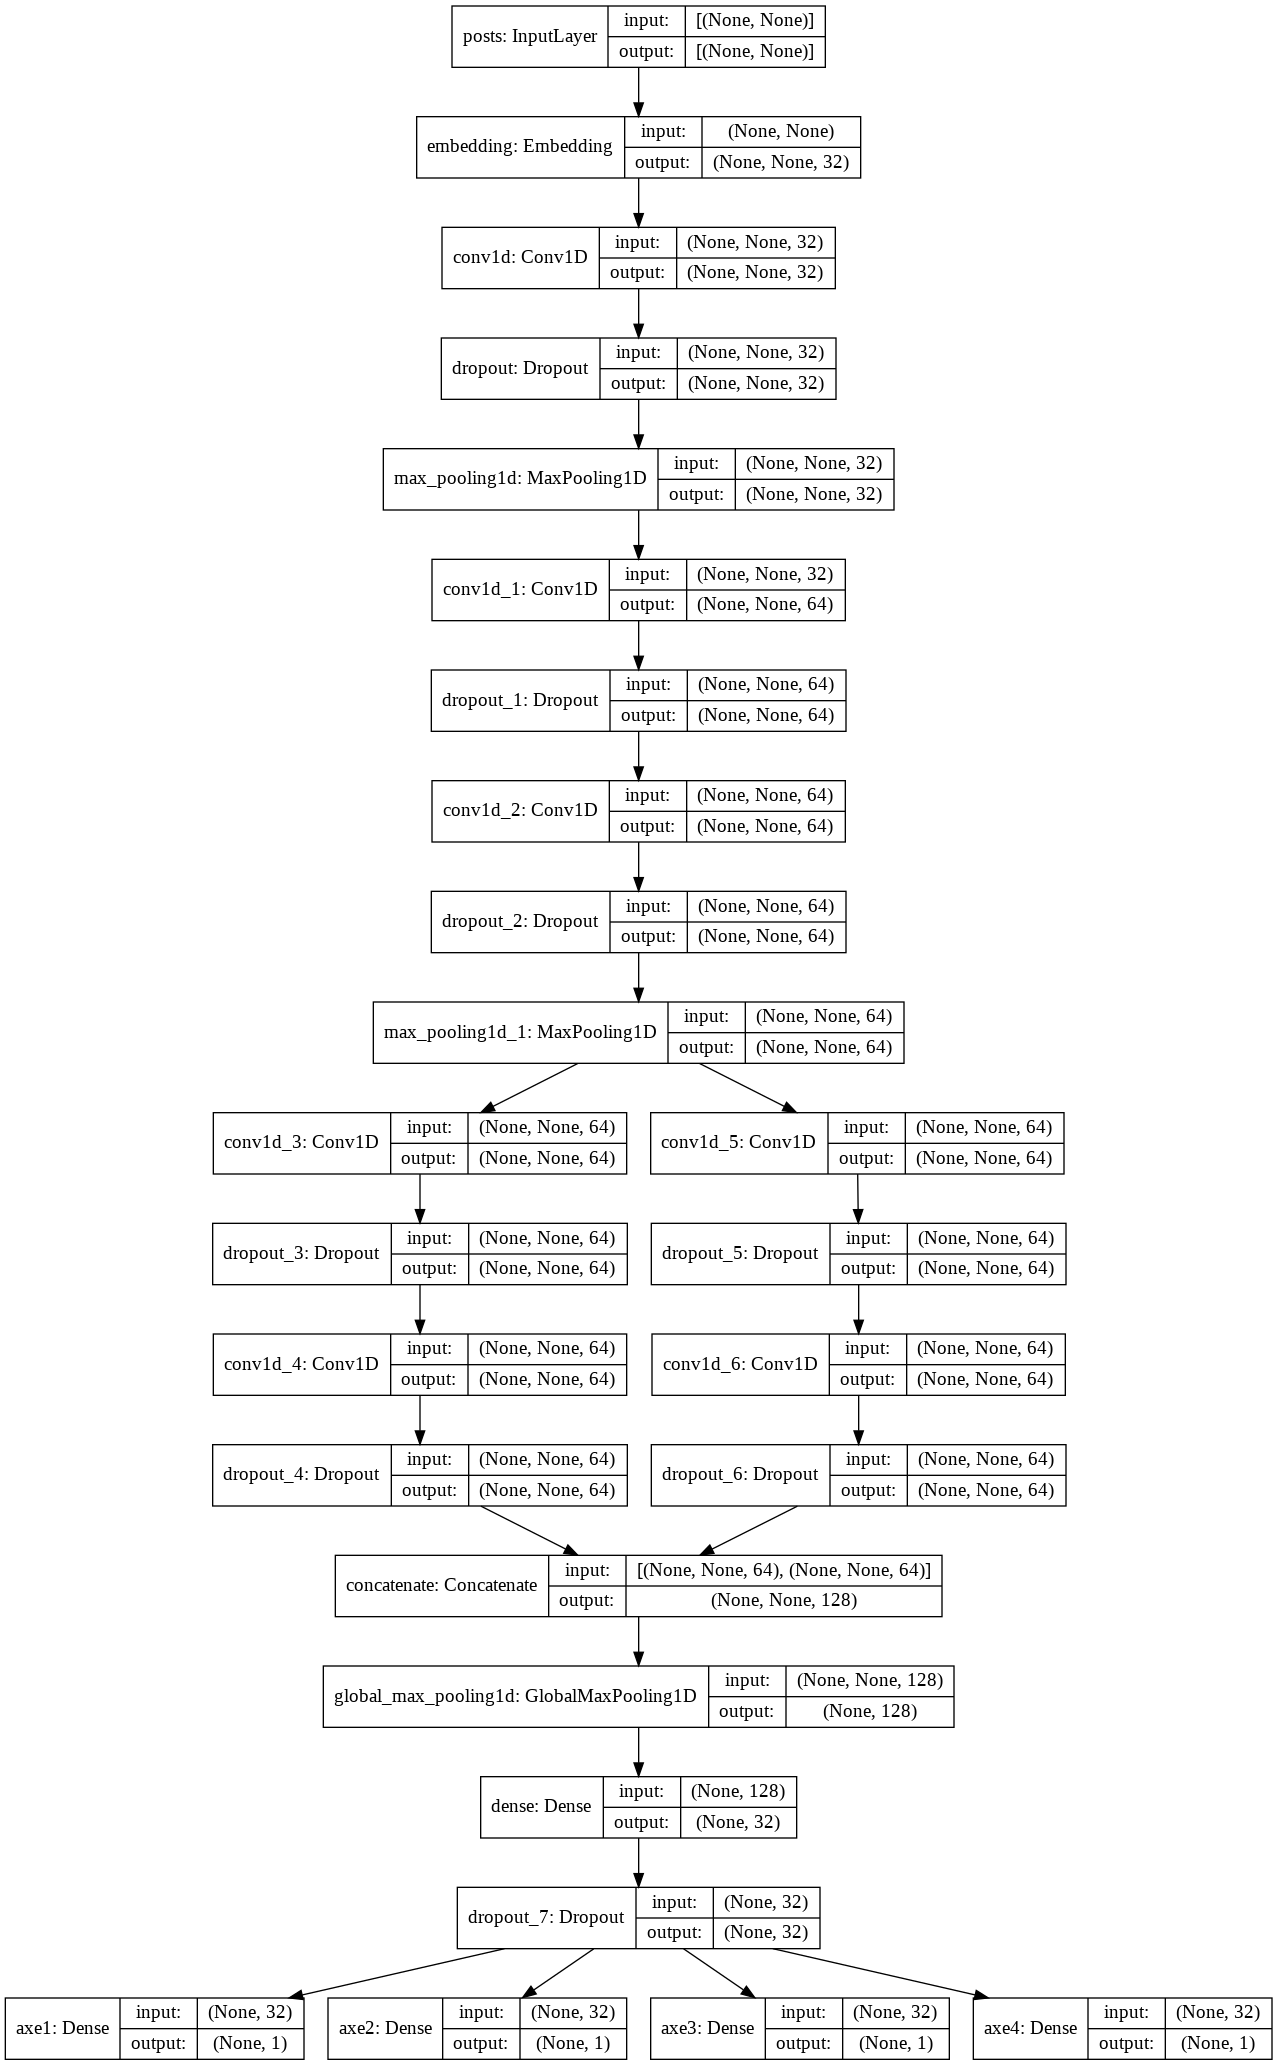

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes = True, to_file='model.png')

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     2842816     posts[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     5152        embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 32)     0           conv1d[0][0]                     
______________________________________________________________________________________________

On utilise "rmsprop" comme optimiseur, la "binary cross entropy" comme fonction de perte et le critère AUC comme métrique. 

In [ ]:
model.compile(optimizer='rmsprop', 
              loss=['binary_crossentropy', 
                    'binary_crossentropy', 
                    'binary_crossentropy', 
                    'binary_crossentropy'],
              metrics=['AUC'])

On fixe arbitrairement le nombre d'époques à 20 pour ce premier modèle.
0n choisit un nombre d'époques assez grand afin de voir si un phénomène de surapprentissage apparait.

In [ ]:
#Fit Model
history = model.fit(X_train, 
          [y1_train, y2_train, y3_train, y4_train], 
          epochs = 20,
          validation_data = (X_val, [y1_val, y2_val, y3_val, y4_val]));

Epoch 1/20
220/220 [==============================] - 17s 31ms/step - loss: 2.6841 - axe1_loss: 0.5708 - axe2_loss: 0.4365 - axe3_loss: 0.6978 - axe4_loss: 0.6958 - axe1_auc: 0.5076 - axe2_auc_1: 0.5321 - axe3_auc_2: 0.5034 - axe4_auc_3: 0.5049 - val_loss: 2.3691 - val_axe1_loss: 0.5472 - val_axe2_loss: 0.4395 - val_axe3_loss: 0.6727 - val_axe4_loss: 0.6718 - val_axe1_auc: 0.6830 - val_axe2_auc_1: 0.7249 - val_axe3_auc_2: 0.7314 - val_axe4_auc_3: 0.6257
Epoch 2/20
220/220 [==============================] - 5s 24ms/step - loss: 2.2265 - axe1_loss: 0.4965 - axe2_loss: 0.3578 - axe3_loss: 0.6620 - axe4_loss: 0.6782 - axe1_auc: 0.7042 - axe2_auc_1: 0.7299 - axe3_auc_2: 0.6474 - axe4_auc_3: 0.5244 - val_loss: 2.3362 - val_axe1_loss: 0.5297 - val_axe2_loss: 0.4411 - val_axe3_loss: 0.6669 - val_axe4_loss: 0.6763 - val_axe1_auc: 0.8077 - val_axe2_auc_1: 0.7334 - val_axe3_auc_2: 0.7205 - val_axe4_auc_3: 0.6045
Epoch 3/20
220/220 [==============================] - 6s 25ms/step - loss: 2.0769 - a

On peut tracer l'évolution de la perte et du critère AUC sur les échantillons de validation et d'entraînement pour chacun des 4 axes.

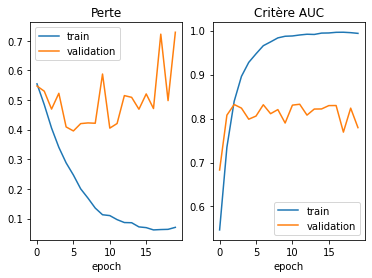

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['axe1_loss'], label="train")
plt.plot(history.history['val_axe1_loss'], label="validation")
plt.title('Perte')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['axe1_auc'], label="train")
plt.plot(history.history['val_axe1_auc'], label="validation")
plt.title('Critère AUC')
plt.xlabel('epoch')
plt.legend()

On remarque un surapprentissage puisqu'à partir d'environ 3 époques la perte sur l'échantillon de validation augmente... Le modèle s'adapte trop aux données de l'échantillon d'entraînement et il n'est pas performant avec de nouvelles données.

On voit aussi que le critère AUC est plus faible sur l'échantillon de validation que sur celui d'entraînement. Cela confirme le surapprentissage.
On rappelle que le but est de maximiser le critère AUC.

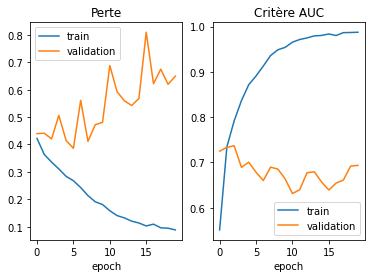

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['axe2_loss'], label="train")
plt.plot(history.history['val_axe2_loss'], label="validation")
plt.title('Perte')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['axe2_auc_1'], label="train")
plt.plot(history.history['val_axe2_auc_1'], label="validation")
plt.title('Critère AUC')
plt.xlabel('epoch')
plt.legend()

Pour le deuxième axe, le constat est le même : la perte augmente sur l'échantillon de validation à partir d'environ 3 époques et l'AUC est plus faible sur celui-ci. On a du suraprentissage.

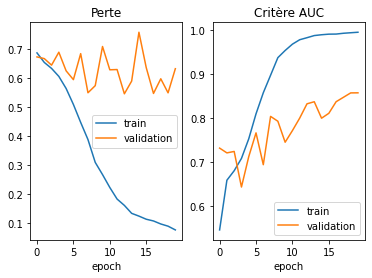

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['axe3_loss'], label="train")
plt.plot(history.history['val_axe3_loss'], label="validation")
plt.title('Perte')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['axe3_auc_2'], label="train")
plt.plot(history.history['val_axe3_auc_2'], label="validation")
plt.title('Critère AUC')
plt.xlabel('epoch')
plt.legend()

Ici, la perte sur l'échantillon de validation n'augmente pas réelement mais elle oscille et ne diminue pas du tout. 
L'AUC augmente au cours des époques sur l'échantillon de validation mais reste en dessous de celui de l'échantillon d'entraînement. 
On a toujours du surapprentissage.
Cependant, on peut noter que sur les 3 premières époques l'AUC est meilleur sur l'échantillon de validation que sur celui d'entraînement.

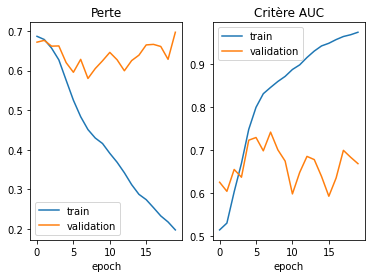

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['axe4_loss'], label="train")
plt.plot(history.history['val_axe4_loss'], label="validation")
plt.title('Perte')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['axe4_auc_3'], label="train")
plt.plot(history.history['val_axe4_auc_3'], label="validation")
plt.title('Critère AUC')
plt.xlabel('epoch')
plt.legend()

On observe les mêmes phénomènes que pour les 3 précédents axes. Il y a du surapprentissage.

## Amélioration du modèle

On réutilise le même modèle mais on va tenter d'améliorer ses résultats en utilisant un callback "early stopping" qui permet d'arrêter l'algorithme lorsque le nombre d'époque est optimal.

In [ ]:
x = Conv1D(32, 5, activation='relu')(embedded_posts)
x = Dropout(0.25)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Dropout(0.25)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Dropout(0.25)(x)
x = MaxPooling1D(5)(x)

branche_a = Conv1D(64, 5, activation='relu')(x)
branche_a = Dropout(0.25)(branche_a)
branche_a = Conv1D(64, 5, activation='relu')(branche_a)
branche_a = Dropout(0.25)(branche_a)

branche_b = Conv1D(64, 5, activation='relu')(x)
branche_b = Dropout(0.25)(branche_b)
branche_b = Conv1D(64, 5, activation='relu')(branche_b)
branche_b = Dropout(0.25)(branche_b)

x = concatenate([branche_a, branche_b], axis=-1)

x = GlobalMaxPooling1D()(x)
x = Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
x = Dropout(0.25)(x)

Axe1_prediction = Dense(1, activation='sigmoid', name='axe1')(x)
Axe2_prediction = Dense(1, activation='sigmoid', name='axe2')(x)
Axe3_prediction = Dense(1, activation='sigmoid', name='axe3')(x)
Axe4_prediction = Dense(1, activation='sigmoid', name='axe4')(x)

model = Model(posts_input, [Axe1_prediction, Axe2_prediction, Axe3_prediction, Axe4_prediction])

In [ ]:
model.compile(optimizer='rmsprop', 
              loss=['binary_crossentropy', 
                    'binary_crossentropy', 
                    'binary_crossentropy', 
                    'binary_crossentropy'],
              metrics=['AUC'])

Voici comment on définit le callback.
On précise la quantité qu'on veut minimiser qui est ici la perte sur l'échantillon de validation.

In [ ]:
import keras 

callbacks_list = [
  keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 1,
  ),
  keras.callbacks.ModelCheckpoint(
      filepath = 'my_model.h5',
      monitor = 'val_loss',
      save_best_only = True,
  )]

In [ ]:
#Fit Model
history = model.fit(X_train, 
          [y1_train, y2_train, y3_train, y4_train], 
          epochs = 20,
          callbacks = callbacks_list,
          validation_data = (X_val, [y1_val, y2_val, y3_val, y4_val]));

Epoch 1/20
220/220 [==============================] - 10s 30ms/step - loss: 2.6185 - axe1_loss: 0.5269 - axe2_loss: 0.3985 - axe3_loss: 0.6990 - axe4_loss: 0.6929 - axe1_auc: 0.6189 - axe2_auc_1: 0.6328 - axe3_auc_2: 0.5180 - axe4_auc_3: 0.5090 - val_loss: 2.3296 - val_axe1_loss: 0.4561 - val_axe2_loss: 0.4616 - val_axe3_loss: 0.6667 - val_axe4_loss: 0.6793 - val_axe1_auc: 0.8111 - val_axe2_auc_1: 0.6879 - val_axe3_auc_2: 0.7047 - val_axe4_auc_3: 0.5502
Epoch 2/20
220/220 [==============================] - 6s 26ms/step - loss: 1.9109 - axe1_loss: 0.2633 - axe2_loss: 0.3008 - axe3_loss: 0.6394 - axe4_loss: 0.6489 - axe1_auc: 0.9412 - axe2_auc_1: 0.8537 - axe3_auc_2: 0.6718 - axe4_auc_3: 0.6244 - val_loss: 2.3110 - val_axe1_loss: 0.4295 - val_axe2_loss: 0.4701 - val_axe3_loss: 0.7066 - val_axe4_loss: 0.6564 - val_axe1_auc: 0.7998 - val_axe2_auc_1: 0.6679 - val_axe3_auc_2: 0.7207 - val_axe4_auc_3: 0.6259
Epoch 3/20
220/220 [==============================] - 6s 26ms/step - loss: 1.4079 - a

Le nombre d'époque optimal est 4.

In [ ]:
res = model.evaluate(X_test, [y1_test, y2_test, y3_test, y4_test], verbose=0)
for i in range(1, 5):
  print("Axe", i, " Loss:", res[i], " AUC:", res[i+4])

Axe 1  Loss: 0.46932879090309143  AUC: 0.8147726655006409
Axe 2  Loss: 0.49199435114860535  AUC: 0.6852881908416748
Axe 3  Loss: 0.48296141624450684  AUC: 0.8575990796089172
Axe 4  Loss: 0.6099197268486023  AUC: 0.6951033473014832


On peut tracer les courbes ROC des différents axes.

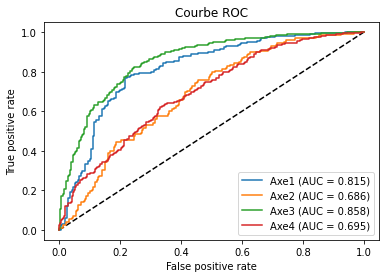

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_keras = model.predict(X_test)

fpr1, tpr1, a = roc_curve(y1_test, y_pred_keras[0])
fpr2, tpr2, a = roc_curve(y2_test, y_pred_keras[1])
fpr3, tpr3, a = roc_curve(y3_test, y_pred_keras[2])
fpr4, tpr4, a = roc_curve(y4_test, y_pred_keras[3])

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Axe1 (AUC = {:.3f})'.format(auc1))
plt.plot(fpr2, tpr2, label='Axe2 (AUC = {:.3f})'.format(auc2))
plt.plot(fpr3, tpr3, label='Axe3 (AUC = {:.3f})'.format(auc3))
plt.plot(fpr4, tpr4, label='Axe4 (AUC = {:.3f})'.format(auc4))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Courbe ROC')
plt.legend(loc='best')
plt.show()

On voit que l'AUC (l'air sous la courbe ROC) est meilleur pour l'axe 3 puis l'axe 1. Ces valeurs sont relativement satisfaisantes.


## Pour aller plus loin
Pour aller plus loin nous aurions pu utiliser un traitement des données textuelles et des réseaux de neurones plus complexes.

Nous aurions aussi pu utiliser des critères plus poussés, un embedding de type Word2Vec et prendre en compte les liens postés par les individus.

Cependant, pour l'embedding Word2Vec nous n'avons pas pu l'essayer car il était impossible de le télécharger sur nos ordinateurs...

Enfin, l'utilisation d'un TensorBoard aurait pu être intéressant et agréable mais cela semble très compliqué sur un notebook fait sur Google Colaboratory.

## Conclusion
Pour conclure ce notebook, on peut dire que cette partie du projet nous a permis de découvrir les réseaux de neurones à sortie multiple. Cela est assez différent des réseaux de neurones classiques puisque ce sont des modèles non séquentiels.

Ce genre de réseaux de neurones sont très utiles puisqu'ils permettent d'avoir des sorties multiples.

Il peut aussi être très intéressant de construire des réseaux de neurones à entrées "multi-type" qui sont aussi des modèles non séquentiels.